In [51]:
import numpy as np
import os 
import h5py
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import glob
from natsort import natsorted
from sklearn.model_selection import train_test_split
import sigpy as sp
import sigpy.mri as mri
from subsample import *
import matplotlib.pyplot as plt
from fastmri.data import transforms, mri_data
from torch.utils.data import DataLoader, Dataset
import pathlib
from network import *
import robust_loss_pytorch_loss_pytorch.general


In [147]:
import sigpy.mri
import numpy as np
import torch
from math import floor, ceil

class MaskFunc:
    """
    Abstract MaskFunc class for creating undersampling masks of a specified shape.
    """

    def __init__(self, accelerations):
        """
        Args:
            accelerations (List[int]): Range of acceleration rates to simulate.
        """
        self.accelerations = accelerations
        self.rng = np.random.RandomState()

    def choose_acceleration(self):
        """
        Chooses a random acceleration rate given a range.
        """
        accel_range = self.accelerations[1] - self.accelerations[0]
        acceleration = self.accelerations[0] + accel_range*self.rng.rand()
        return acceleration

class PoissonDiskMaskFunc(MaskFunc):
    """
    PoissonDiskMaskFunc creates a 2D Poisson disk undersampling mask.
    """
    def __init__(self, accelerations, calib_size):
        super().__init__(accelerations)
        self.calib_size = [calib_size, calib_size]

    def __call__(self, out_shape, seed=None):
        #self.rng.seed(seed)

        # Design parameters for mask
        nky = out_shape[0]
        nkz = out_shape[1]
        acceleration = self.choose_acceleration()

        # Generate undersampling mask
        mask = sigpy.mri.poisson([nky, nkz], acceleration,
                calib=self.calib_size,
                dtype=np.float32)

        return mask    

In [148]:
class kneeData(Dataset):
    def __init__(self, root, acc=[9, 12]):
        super().__init__()
        self.examples = []
        Files = list(pathlib.Path(root).glob('*.h5'))
        for fname in sorted(Files):
            data = h5py.File(fname, 'r')
            ksp = data['kspace']

            num_slices = ksp.shape[0]
            self.examples += [(fname, slice_num)
                              for slice_num in range(num_slices)]
        self.mask_func = PoissonDiskMaskFunc(accelerations=acc,
                                             calib_size=20)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        fname, sl = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, sens = hr['kspace'][sl], hr['sens'][sl]
        kspace = kspace / np.std(np.abs(kspace)) / 5
        
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_comb = np.sum(im_coil * np.conj(sens), axis=0)
#        
        
        mask = self.mask_func(im_comb.shape)
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask
        mask = np.expand_dims(mask, axis=-1)
        
        masked_kspace = transforms.to_tensor(masked_kspace)
        mask = transforms.to_tensor(mask)
        sens = transforms.to_tensor(sens)
        im_comb = np.expand_dims(im_comb, axis=0)
        im_comb = transforms.to_tensor(im_comb)
                        
        return masked_kspace, mask.byte(), sens, im_comb

In [149]:
dset = kneeData(root='data/div_knee3d/Test')

In [150]:
trainloader = DataLoader(dset, batch_size=1, shuffle=True, num_workers=4)

In [151]:
tmp = iter(trainloader)

In [152]:
k, m, s, i = next(tmp)
print(k.shape, m.shape, s.shape, i.shape)

torch.Size([1, 8, 256, 320, 2]) torch.Size([1, 1, 256, 320, 1]) torch.Size([1, 8, 256, 320, 2]) torch.Size([1, 1, 256, 320, 2])


In [153]:
varnet = VarNet2()

In [154]:
out = varnet(k, m, s)

In [155]:
print(out[0].shape)

torch.Size([1, 1, 256, 320, 2])


In [156]:
print(out[0].shape, out[1].shape)

torch.Size([1, 1, 256, 320, 2]) torch.Size([1, 8, 256, 320, 2])


In [157]:
estY  = out[0]

In [158]:
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')

In [159]:
loss = torch.mean(adaptive.lossfun(torch.flatten(i - estY)[:,None]))

In [160]:
loss.backward()

In [161]:
loss.item()

1.270216464996338

In [162]:
import torch.nn.functional as F

In [163]:
criterion = nn.L1Loss()

In [164]:
tmp = criterion(estY, i)

In [165]:
tmp.item()

0.330411821603775

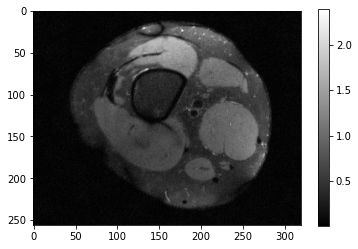

In [166]:
tmp2 = from_pytorch(i, iscomplex=True).squeeze()
plt.imshow(np.abs(tmp2),cmap='gray')
plt.colorbar()

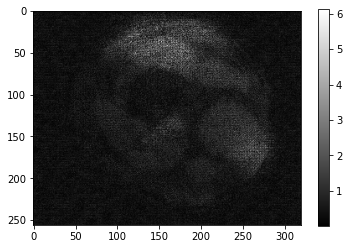

In [167]:
tmp2 = from_pytorch(estY.detach(), iscomplex=True).squeeze()
plt.imshow(np.abs(tmp2),cmap='gray')
plt.colorbar()